tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


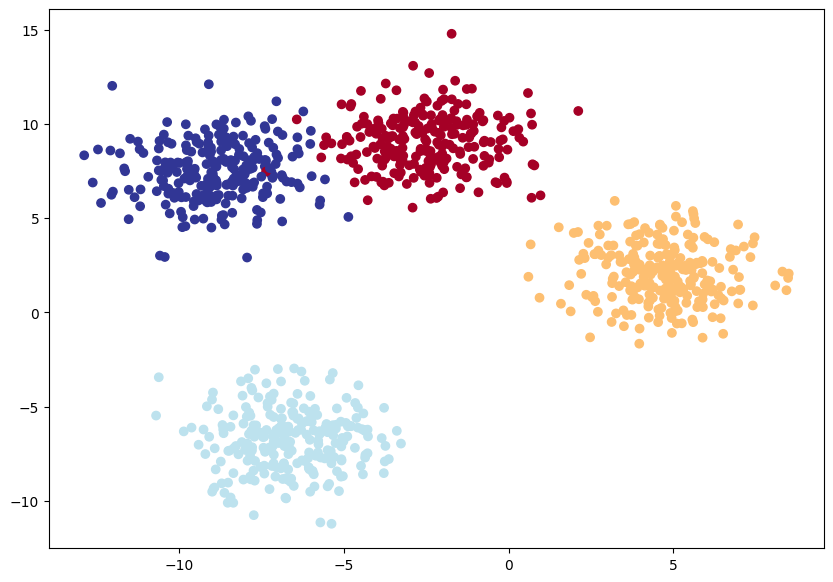

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [3]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [4]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance


In [5]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]


tensor([[ 0.6212,  1.4527,  0.3690,  0.3299],
        [ 1.0363,  0.9427,  0.0274,  0.2143],
        [-0.8571, -2.4548, -0.5961,  0.2924],
        [-0.3642, -1.4356, -0.3824,  0.2826],
        [ 0.8013,  0.5234, -0.0491,  0.2241]], grad_fn=<SliceBackward0>)

In [6]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])


tensor([[ 0.7245,  1.5408,  0.3659,  0.3180],
        [ 0.6635, -0.3161, -0.3202,  0.1833],
        [-0.6940, -1.9191, -0.4497,  0.3047],
        [ 0.3884,  0.9465,  0.2586,  0.3326],
        [ 1.1533,  1.4496,  0.1791,  0.2327]], grad_fn=<SliceBackward0>)
tensor([[0.2161, 0.4889, 0.1510, 0.1439],
        [0.4223, 0.1586, 0.1579, 0.2612],
        [0.1892, 0.0556, 0.2416, 0.5137],
        [0.2188, 0.3822, 0.1921, 0.2069],
        [0.3204, 0.4310, 0.1210, 0.1276]], grad_fn=<SliceBackward0>)


In [7]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [8]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2161, 0.4889, 0.1510, 0.1439], grad_fn=<SelectBackward0>)
tensor(1)


In [10]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [11]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15760, Acc: 42.88% | Test Loss: 0.63459, Test Acc: 75.00%
Epoch: 10 | Loss: 0.15781, Acc: 99.12% | Test Loss: 0.14306, Test Acc: 99.50%
Epoch: 20 | Loss: 0.08623, Acc: 99.12% | Test Loss: 0.07779, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06241, Acc: 99.12% | Test Loss: 0.05460, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05106, Acc: 99.12% | Test Loss: 0.04318, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04454, Acc: 99.12% | Test Loss: 0.03649, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04036, Acc: 99.12% | Test Loss: 0.03212, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03748, Acc: 99.12% | Test Loss: 0.02906, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03539, Acc: 99.12% | Test Loss: 0.02680, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03380, Acc: 99.12% | Test Loss: 0.02505, Test Acc: 99.50%


In [12]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  8.0743,  13.5348, -10.2468,  -5.4340],
        [  2.0795, -13.1302,   0.2176,   7.7386],
        [-12.0634, -17.2733,  15.5189,   7.0995],
        [  3.9797,   9.5802,  -5.3768,  -4.1321],
        [ 10.7473,   5.9789, -11.8068,  -0.8126],
        [  1.9239, -16.4845,   0.9144,   9.5173],
        [-11.5950, -13.5883,  14.4455,   5.2059],
        [  8.2118,   0.8830,  -8.3683,   1.4223],
        [-13.6802, -23.5698,  18.1982,  10.1691],
        [  8.9754,   2.7142,  -9.4512,   0.5892]])

In [13]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


In [15]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

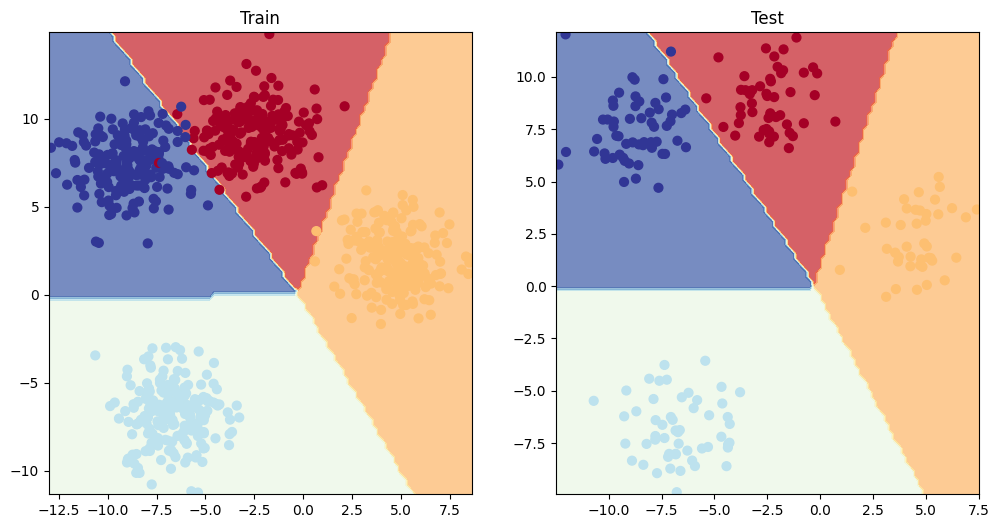

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)